# Tacotron 2 TTS

## **Part 1: Initial Setup**

In [1]:
#@markdown # <font color="black"> 1. Check the GPU </font>⚠️
#@markdown ---
#@markdown #### This code requires a GPU to run and has been tested with the <font color="green">**T4 GPU**</font>. Run this cell to see what you are currently using.

!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-f992cab3-be20-1289-053d-c4c35e6711fc)


In [2]:
#@markdown ## <font color="black"> 2. Mount your Google Drive 📂
#@markdown ---
#@markdown #### This allows the code to save .wav files, save the model while training and export the final model.

#Google Drive Authentication Token
from google.colab import drive
drive.mount('drive', force_remount=True)

Mounted at drive


In [3]:
#@markdown ## <font color="black"> 3. Install Tacotron 2 with English Phonetics  📦
#@markdown ---
#@markdown #### This loads a pretrained version of Tacotron 2 with ARPAbet from [this](https://github.com/justinjohn0306/ARPAtaco2.git) git repo. Model handling functions are initialised here.


%matplotlib inline
import os
import io
%cd /content/
if not os.path.isdir("/content/TTS-TT2/"):
  print("Cloning justinjohn0306/TTS-TT2")
  !git clone https://github.com/justinjohn0306/ARPAtaco2.git TTS-TT2
  %cd /content/TTS-TT2/
  !git submodule init
  !git submodule update
%cd /content/TTS-TT2/
#NVIDIA's requirements
#I believe Colab gives us PyTorch and TF by default so we don't need anything else
#Versions specified in requirements.txt have conflicts so that's why we simply get current versions
print("Downloading tacotron2 requirements")
!pip install matplotlib numpy inflect scipy Unidecode pillow
#Our requirements
#We'll need gdown to download some really cool things
!pip install git+https://github.com/wkentaro/gdown.git
import gdown
!git submodule init
!git submodule update
!pip install ffmpeg-normalize
!pip install -q unidecode tensorboardX
!apt-get -qq install sox
!apt-get install pv
!apt-get install jq
!wget https://raw.githubusercontent.com/tonikelope/megadown/master/megadown -O megadown.sh
!chmod 755 megadown.sh
#Download NVIDIA's LJSpeech model
# Download NVIDIA's LJSpeech model using wget
tt2_pretrained_url = "https://github.com/justinjohn0306/ARPAtaco2/releases/download/pretrained_model/tacotron2_statedict.pt"
tt2_pretrained_path = "/content/TTS-TT2/tacotron2_statedict.pt"

if not os.path.isfile(tt2_pretrained_path):
  print("Downloading tt2 pretrained model using wget")
  !wget {tt2_pretrained_url} -O {tt2_pretrained_path}


#tt2_pretrained = "https://drive.google.com/uc?id=1c5ZTuT7J08wLUoVZ2KkUs_VdZuJ86ZqA"
#if not os.path.isfile("/content/TTS-TT2/pretrained_model"):
  #print("Downloading tt2 pretrained")
  #gdown.download(tt2_pretrained, "/content/TTS-TT2/pretrained_model", quiet=False)

latest_downloaded = None

import time
import logging

logging.getLogger('matplotlib').setLevel(logging.WARNING)
logging.getLogger('numba').setLevel(logging.WARNING)
logging.getLogger('librosa').setLevel(logging.WARNING)


import argparse
import math
from numpy import finfo

import torch
from distributed import apply_gradient_allreduce
import torch.distributed as dist
from torch.utils.data.distributed import DistributedSampler
from torch.utils.data import DataLoader

from model import Tacotron2
from data_utils import TextMelLoader, TextMelCollate
from loss_function import Tacotron2Loss
from logger import Tacotron2Logger
from hparams import create_hparams

import random
import numpy as np

import layers
from utils import load_wav_to_torch, load_filepaths_and_text
from text import text_to_sequence
from math import e
#from tqdm import tqdm # Terminal
#from tqdm import tqdm_notebook as tqdm # Legacy Notebook TQDM
from tqdm.notebook import tqdm # Modern Notebook TQDM
from distutils.dir_util import copy_tree
import matplotlib.pylab as plt

def download_from_google_drive(file_id, file_name):
  # download a file from the Google Drive link
  !rm -f ./cookie
  !curl -c ./cookie -s -L "https://drive.google.com/uc?export=download&id={file_id}" > /dev/null
  confirm_text = !awk '/download/ {print $NF}' ./cookie
  confirm_text = confirm_text[0]
  !curl -Lb ./cookie "https://drive.google.com/uc?export=download&confirm={confirm_text}&id={file_id}" -o {file_name}

def create_mels():
    print("Generating Mels")
    stft = layers.TacotronSTFT(
                hparams.filter_length, hparams.hop_length, hparams.win_length,
                hparams.n_mel_channels, hparams.sampling_rate, hparams.mel_fmin,
                hparams.mel_fmax)
    def save_mel(filename):
        audio, sampling_rate = load_wav_to_torch(filename)
        if sampling_rate != stft.sampling_rate:
            raise ValueError("{} {} SR doesn't match target {} SR".format(filename,
                sampling_rate, stft.sampling_rate))
        audio_norm = audio / hparams.max_wav_value
        audio_norm = audio_norm.unsqueeze(0)
        audio_norm = torch.autograd.Variable(audio_norm, requires_grad=False)
        melspec = stft.mel_spectrogram(audio_norm)
        melspec = torch.squeeze(melspec, 0).cpu().numpy()
        np.save(filename.replace('.wav', ''), melspec)

    import glob
    wavs = glob.glob('wavs/*.wav')
    for i in tqdm(wavs):
        save_mel(i)


def reduce_tensor(tensor, n_gpus):
    rt = tensor.clone()
    dist.all_reduce(rt, op=dist.reduce_op.SUM)
    rt /= n_gpus
    return rt


def init_distributed(hparams, n_gpus, rank, group_name):
    assert torch.cuda.is_available(), "Distributed mode requires CUDA."
    print("Initializing Distributed")

    # Set cuda device so everything is done on the right GPU.
    torch.cuda.set_device(rank % torch.cuda.device_count())

    # Initialize distributed communication
    dist.init_process_group(
        backend=hparams.dist_backend, init_method=hparams.dist_url,
        world_size=n_gpus, rank=rank, group_name=group_name)

    print("Done initializing distributed")


def prepare_dataloaders(hparams):
    # Get data, data loaders and collate function ready
    trainset = TextMelLoader(hparams.training_files, hparams)
    valset = TextMelLoader(hparams.validation_files, hparams)
    collate_fn = TextMelCollate(hparams.n_frames_per_step)

    if hparams.distributed_run:
        train_sampler = DistributedSampler(trainset)
        shuffle = False
    else:
        train_sampler = None
        shuffle = True

    train_loader = DataLoader(trainset, num_workers=1, shuffle=shuffle,
                              sampler=train_sampler,
                              batch_size=hparams.batch_size, pin_memory=False,
                              drop_last=True, collate_fn=collate_fn)
    return train_loader, valset, collate_fn


def prepare_directories_and_logger(output_directory, log_directory, rank):
    if rank == 0:
        if not os.path.isdir(output_directory):
            os.makedirs(output_directory)
            os.chmod(output_directory, 0o775)
        logger = Tacotron2Logger(os.path.join(output_directory, log_directory))
    else:
        logger = None
    return logger


def load_model(hparams):
    model = Tacotron2(hparams).cuda()
    if hparams.fp16_run:
        model.decoder.attention_layer.score_mask_value = finfo('float16').min

    if hparams.distributed_run:
        model = apply_gradient_allreduce(model)

    return model


def warm_start_model(checkpoint_path, model, ignore_layers):
    assert os.path.isfile(checkpoint_path)
    print("Warm starting model from checkpoint '{}'".format(checkpoint_path))
    checkpoint_dict = torch.load(checkpoint_path, map_location='cpu')
    model_dict = checkpoint_dict['state_dict']
    if len(ignore_layers) > 0:
        model_dict = {k: v for k, v in model_dict.items()
                      if k not in ignore_layers}
        dummy_dict = model.state_dict()
        dummy_dict.update(model_dict)
        model_dict = dummy_dict
    model.load_state_dict(model_dict)
    return model


def load_checkpoint(checkpoint_path, model, optimizer):
    assert os.path.isfile(checkpoint_path)
    print("Loading checkpoint '{}'".format(checkpoint_path))
    checkpoint_dict = torch.load(checkpoint_path, map_location='cpu')
    model.load_state_dict(checkpoint_dict['state_dict'])
    optimizer.load_state_dict(checkpoint_dict['optimizer'])
    learning_rate = checkpoint_dict['learning_rate']
    iteration = checkpoint_dict['iteration']
    print("Loaded checkpoint '{}' from iteration {}" .format(
        checkpoint_path, iteration))
    return model, optimizer, learning_rate, iteration


def save_checkpoint(model, optimizer, learning_rate, iteration, filepath):
    import random
    if True:
        print("Saving model and optimizer state at iteration {} to {}".format(
            iteration, filepath))
        try:
            torch.save({'iteration': iteration,
                    'state_dict': model.state_dict(),
                    'optimizer': optimizer.state_dict(),
                    'learning_rate': learning_rate}, filepath)
        except KeyboardInterrupt:
            print("interrupt received while saving, waiting for save to complete.")
            torch.save({'iteration': iteration,'state_dict': model.state_dict(),'optimizer': optimizer.state_dict(),'learning_rate': learning_rate}, filepath)
        print("Model Saved")

def plot_alignment(alignment, info=None):
    %matplotlib inline
    fig, ax = plt.subplots(figsize=(int(alignment_graph_width/100), int(alignment_graph_height/100)))
    im = ax.imshow(alignment, cmap='inferno', aspect='auto', origin='lower',
                   interpolation='none')
    ax.autoscale(enable=True, axis="y", tight=True)
    fig.colorbar(im, ax=ax)
    xlabel = 'Decoder timestep'
    if info is not None:
        xlabel += '\n\n' + info
    plt.xlabel(xlabel)
    plt.ylabel('Encoder timestep')
    plt.tight_layout()
    fig.canvas.draw()
    plt.show()

def validate(model, criterion, valset, iteration, batch_size, n_gpus,
             collate_fn, logger, distributed_run, rank, epoch, start_eposh, learning_rate):
    """Handles all the validation scoring and printing"""
    model.eval()
    with torch.no_grad():
        val_sampler = DistributedSampler(valset) if distributed_run else None
        val_loader = DataLoader(valset, sampler=val_sampler, num_workers=1,
                                shuffle=False, batch_size=batch_size,
                                pin_memory=False, collate_fn=collate_fn)

        val_loss = 0.0
        for i, batch in enumerate(val_loader):
            x, y = model.parse_batch(batch)
            y_pred = model(x)
            loss = criterion(y_pred, y)
            if distributed_run:
                reduced_val_loss = reduce_tensor(loss.data, n_gpus).item()
            else:
                reduced_val_loss = loss.item()
            val_loss += reduced_val_loss
        val_loss = val_loss / (i + 1)

    model.train()
    if rank == 0:
        print("Epoch: {} Validation loss {}: {:9f}  Time: {:.1f}m LR: {:.6f}".format(epoch, iteration, val_loss,(time.perf_counter()-start_eposh)/60, learning_rate))
        logger.log_validation(val_loss, model, y, y_pred, iteration)
        if hparams.show_alignments:
            %matplotlib inline
            _, mel_outputs, gate_outputs, alignments = y_pred
            idx = random.randint(0, alignments.size(0) - 1)
            plot_alignment(alignments[idx].data.cpu().numpy().T)

def train(output_directory, log_directory, checkpoint_path, warm_start, n_gpus,
          rank, group_name, hparams, log_directory2, save_interval, backup_interval):
    """Training and validation logging results to tensorboard and stdout

    Params
    ------
    output_directory (string): directory to save checkpoints
    log_directory (string) directory to save tensorboard logs
    checkpoint_path(string): checkpoint path
    n_gpus (int): number of gpus
    rank (int): rank of current gpu
    hparams (object): comma separated list of "name=value" pairs.
    """
    if hparams.distributed_run:
        init_distributed(hparams, n_gpus, rank, group_name)

    torch.manual_seed(hparams.seed)
    torch.cuda.manual_seed(hparams.seed)

    model = load_model(hparams)
    learning_rate = hparams.learning_rate
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,
                                 weight_decay=hparams.weight_decay)

    if hparams.fp16_run:
        from apex import amp
        model, optimizer = amp.initialize(
            model, optimizer, opt_level='O2')

    if hparams.distributed_run:
        model = apply_gradient_allreduce(model)

    criterion = Tacotron2Loss()

    logger = prepare_directories_and_logger(
        output_directory, log_directory, rank)

    train_loader, valset, collate_fn = prepare_dataloaders(hparams)

    # Load checkpoint if one exists
    iteration = 0
    epoch_offset = 0
    if checkpoint_path is not None and os.path.isfile(checkpoint_path):
        if warm_start:
            model = warm_start_model(
                checkpoint_path, model, hparams.ignore_layers)
        else:
            model, optimizer, _learning_rate, iteration = load_checkpoint(
                checkpoint_path, model, optimizer)
            if hparams.use_saved_learning_rate:
                learning_rate = _learning_rate
            iteration += 1  # next iteration is iteration + 1
            epoch_offset = max(0, int(iteration / len(train_loader)))
    else:
      os.path.isfile("/content/TTS-TT2/pretrained_model")
      %cd /dev/null
      !/content/TTS-TT2/megadown.sh https://mega.nz/#!WXY3RILA!KyoGHtfB_sdhmLFoykG2lKWhh0GFdwMkk7OwAjpQHRo --o pretrained_model
      %cd /content/TTS-TT2
      model = warm_start_model("/content/TTS-TT2/pretrained_model", model, hparams.ignore_layers)
      # download LJSpeech pretrained model if no checkpoint already exists

    start_eposh = time.perf_counter()
    learning_rate = 0.0
    model.train()
    is_overflow = False
    # ================ MAIN TRAINNIG LOOP! ===================
    for epoch in tqdm(range(epoch_offset, hparams.epochs)):
        print("\nStarting Epoch: {} Iteration: {}".format(epoch, iteration))
        start_eposh = time.perf_counter() # eposh is russian, not a typo
        for i, batch in tqdm(enumerate(train_loader), total=len(train_loader)):
            start = time.perf_counter()
            if iteration < hparams.decay_start: learning_rate = hparams.A_
            else: iteration_adjusted = iteration - hparams.decay_start; learning_rate = (hparams.A_*(e**(-iteration_adjusted/hparams.B_))) + hparams.C_
            learning_rate = max(hparams.min_learning_rate, learning_rate) # output the largest number
            for param_group in optimizer.param_groups:
                param_group['lr'] = learning_rate

            model.zero_grad()
            x, y = model.parse_batch(batch)
            y_pred = model(x)

            loss = criterion(y_pred, y)
            if hparams.distributed_run:
                reduced_loss = reduce_tensor(loss.data, n_gpus).item()
            else:
                reduced_loss = loss.item()
            if hparams.fp16_run:
                with amp.scale_loss(loss, optimizer) as scaled_loss:
                    scaled_loss.backward()
            else:
                loss.backward()

            if hparams.fp16_run:
                grad_norm = torch.nn.utils.clip_grad_norm_(
                    amp.master_params(optimizer), hparams.grad_clip_thresh)
                is_overflow = math.isnan(grad_norm)
            else:
                grad_norm = torch.nn.utils.clip_grad_norm_(
                    model.parameters(), hparams.grad_clip_thresh)

            optimizer.step()

            if not is_overflow and rank == 0:
                duration = time.perf_counter() - start
                logger.log_training(
                    reduced_loss, grad_norm, learning_rate, duration, iteration)
                #print("Batch {} loss {:.6f} Grad Norm {:.6f} Time {:.6f}".format(iteration, reduced_loss, grad_norm, duration), end='\r', flush=True)

            iteration += 1
        validate(model, criterion, valset, iteration,
                 hparams.batch_size, n_gpus, collate_fn, logger,
                 hparams.distributed_run, rank, epoch, start_eposh, learning_rate)
        if (epoch+1) % save_interval == 0 or (epoch+1) == hparams.epochs: # not sure if the latter is necessary
            save_checkpoint(model, optimizer, learning_rate, iteration, checkpoint_path)
        if backup_interval > 0 and (epoch+1) % backup_interval == 0:
            save_checkpoint(model, optimizer, learning_rate, iteration, checkpoint_path + "_epoch_%s" % (epoch+1))
        if log_directory2 != None:
            copy_tree(log_directory, log_directory2)
def check_dataset(hparams):
    from utils import load_wav_to_torch, load_filepaths_and_text
    import os
    import numpy as np
    def check_arr(filelist_arr):
        for i, file in enumerate(filelist_arr):
            if len(file) > 2:
                print("|".join(file), "\nhas multiple '|', this may not be an error.")
            if hparams.load_mel_from_disk and '.wav' in file[0]:
                print("[WARNING]", file[0], " in filelist while expecting .npy .")
            else:
                if not hparams.load_mel_from_disk and '.npy' in file[0]:
                    print("[WARNING]", file[0], " in filelist while expecting .wav .")
            if (not os.path.exists(file[0])):
                print("|".join(file), "\n[WARNING] does not exist.")
            if len(file[1]) < 3:
                print("|".join(file), "\n[info] has no/very little text.")
            if not ((file[1].strip())[-1] in r"!?,.;:"):
                print("|".join(file), "\n[info] has no ending punctuation.")
            mel_length = 1
            if hparams.load_mel_from_disk and '.npy' in file[0]:
                melspec = torch.from_numpy(np.load(file[0], allow_pickle=True))
                mel_length = melspec.shape[1]
            if mel_length == 0:
                print("|".join(file), "\n[WARNING] has 0 duration.")
    print("Checking Training Files")
    audiopaths_and_text = load_filepaths_and_text(hparams.training_files) # get split lines from training_files text file.
    check_arr(audiopaths_and_text)
    print("Checking Validation Files")
    audiopaths_and_text = load_filepaths_and_text(hparams.validation_files) # get split lines from validation_files text file.
    check_arr(audiopaths_and_text)
    print("Finished Checking")

warm_start=False#sorry bout that
n_gpus=1
rank=0
group_name=None

# ---- DEFAULT PARAMETERS DEFINED HERE ----
hparams = create_hparams()
model_filename = 'current_model'
hparams.training_files = "filelists/clipper_train_filelist.txt"
hparams.validation_files = "filelists/clipper_val_filelist.txt"
#hparams.use_mmi=True,          # not used in this notebook
#hparams.use_gaf=True,          # not used in this notebook
#hparams.max_gaf=0.5,           # not used in this notebook
#hparams.drop_frame_rate = 0.2  # not used in this notebook
hparams.p_attention_dropout=0.1
hparams.p_decoder_dropout=0.1
hparams.decay_start = 15000
hparams.A_ = 5e-4
hparams.B_ = 8000
hparams.C_ = 0
hparams.min_learning_rate = 1e-5
generate_mels = True
hparams.show_alignments = True
alignment_graph_height = 600
alignment_graph_width = 1000
hparams.batch_size = 32
hparams.load_mel_from_disk = True
hparams.ignore_layers = []
hparams.epochs = 10000
torch.backends.cudnn.enabled = hparams.cudnn_enabled
torch.backends.cudnn.benchmark = hparams.cudnn_benchmark
output_directory = '/content/drive/My Drive/colab/outdir' # Location to save Checkpoints
log_directory = '/content/TTS-TT2/logs' # Location to save Log files locally
log_directory2 = '/content/drive/My Drive/colab/logs' # Location to copy log files (done at the end of each epoch to cut down on I/O)
checkpoint_path = output_directory+(r'/')+model_filename

# ---- Replace .wav with .npy in filelists ----
!sed -i -- 's,.wav|,.npy|,g' filelists/*.txt
!sed -i -- 's,.wav|,.npy|,g' {hparams.training_files}
!sed -i -- 's,.wav|,.npy|,g' {hparams.validation_files}
# ---- Replace .wav with .npy in filelists ----

%cd /content/TTS-TT2

data_path = 'wavs'
!mkdir {data_path}

/content
Cloning justinjohn0306/TTS-TT2
Cloning into 'TTS-TT2'...
remote: Enumerating objects: 89, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 89 (delta 2), reused 1 (delta 0), pack-reused 80 (from 1)
Receiving objects: 100% (89/89), 7.11 MiB | 8.60 MiB/s, done.
Resolving deltas: 100% (30/30), done.
/content/TTS-TT2
/content/TTS-TT2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 17.2 MB/s eta 0:00:00
  Cloning https://github.com/wkentaro/gdown.git to /tmp/pip-req-build-t18nt147
  Running command git clone --filter=blob:none --quiet https://github.com/wkentaro/gdown.git /tmp/pip-req-build-t18nt147
  Resolved https://github.com/wkentaro/gdown.git to commit eeb6995f2e077991576b35956983bbefe34cf057
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.2/56.2 kB 5.2 MB/s eta 0:00:00
  

/content/TTS-TT2/text/__init__.py:84: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  return s in _symbol_to_id and s is not '_' and s is not '~'
/content/TTS-TT2/text/__init__.py:84: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  return s in _symbol_to_id and s is not '_' and s is not '~'


sed: can't read filelists/clipper_train_filelist.txt: No such file or directory
sed: can't read filelists/clipper_val_filelist.txt: No such file or directory
/content/TTS-TT2


## 4. Provide voice samples 🎤
---
#### ⚠️ Voice samples must be between 3-12 seconds.

In [26]:
#@markdown ### Option 1: Record samples in this notebook
#@markdown ---
#@markdown #### Run this cell and click the play icon to begin recording samples. If you are prompted to grant the code access to your microphone, give access and then re-run this cell.

# Import necessary libraries
from IPython.display import display, Audio, HTML, Javascript, clear_output
from google.colab import output
import os
import uuid
import base64

os.makedirs('/content/user-wavs', exist_ok=True)

# JavaScript to record audio with start and stop buttons and display the recording state
RECORD_AUDIO_JS = """
let recorder, audioChunks, startTime, timerInterval;

async function startRecording() {
  const stream = await navigator.mediaDevices.getUserMedia({ audio: true });
  recorder = new MediaRecorder(stream);
  audioChunks = [];

  recorder.ondataavailable = event => audioChunks.push(event.data);
  recorder.start();

  document.getElementById("start-btn").disabled = true;
  document.getElementById("stop-btn").disabled = false;
  document.getElementById("recording-status").innerText = "Recording...";

  // Start timer
  startTime = Date.now();
  timerInterval = setInterval(updateRecordingTime, 100);
}

function stopRecording() {
  recorder.stop();

  recorder.onstop = async () => {
    clearInterval(timerInterval);
    document.getElementById("recording-status").innerText = "Not Recording";

    const audioBlob = new Blob(audioChunks, { type: 'audio/wav' });
    const reader = new FileReader();
    reader.readAsDataURL(audioBlob);
    reader.onloadend = () => {
      const base64data = reader.result.split(',')[1];
      google.colab.kernel.invokeFunction('notebook.save_audio', [base64data], {});
    };
  };

  document.getElementById("start-btn").disabled = false;
  document.getElementById("stop-btn").disabled = true;
}

function updateRecordingTime() {
  const elapsedTime = Math.floor((Date.now() - startTime) / 1000); // in seconds
  const minutes = Math.floor(elapsedTime / 60);
  const seconds = elapsedTime % 60;
  document.getElementById("recording-status").innerText = `Recording... (${minutes}:${seconds.toString().padStart(2, '0')})`;
}
"""

# Function to save base64 audio data to /wav folder and update displayed recordings
def save_audio(data):
    file_name = f"/content/user-wavs/recording_{uuid.uuid4()}.wav"
    with open(file_name, "wb") as f:
        f.write(base64.b64decode(data))
    clear_output(wait=True)  # Clear previous output
    display_record_buttons()  # Redisplay buttons and status
    display_recordings()      # Update recordings list

# Register the save_audio function
output.register_callback('notebook.save_audio', save_audio)

# Function to display the start/stop buttons, recording status, and trigger recording
def display_record_buttons():
    display(HTML(f"""
        <style>
            #audio-box {{
              display: inline-block;
              height: 54px;
              background-color: #f2f2f2;
              border-radius: 27px;
              padding: 0 20px 0 12px;
              font-size: 16px;
              margin-bottom: 10px;
            }}
            #start-btn, #stop-btn {{
                height: 54px;
                width: 27px;
                background: none;
                border: none;
                cursor: pointer;
                line-height: 20px;
            }}
            #stop-btn{{
              font-size: 20px;
              margin-right: 10px;
            }}
        </style>
        <div id="audio-box">
        <button id="start-btn" onclick="startRecording()">►</button>
        <button id="stop-btn" onclick="stopRecording()" disabled>■</button>
        <span id="recording-status">Not Recording</span>
        </div>
    """))
    display(Javascript(RECORD_AUDIO_JS))

# Function to list and display all recorded audio files in /wav folder
def display_recordings():
    files = [f for f in os.listdir('/content/user-wavs') if f.endswith('.wav')]
    if files:
        file_list_html = "<ul>" + "".join(f"<li>{file}</li>" for file in files) + "</ul>"
        display(HTML(f"<p>Current files:</p>{file_list_html}"))
    else:
        display(HTML("<p>No files saved yet.</p>"))

# Display the start/stop buttons, recording status, and current recordings
display_record_buttons()
display_recordings()


<IPython.core.display.Javascript object>

In [29]:
#@markdown ### Option 2: Upload Pre-recorded .wav Files
#@markdown ---
#@markdown #### Run this cell and click the upload button to upload recorded .wav files

import ipywidgets as widgets
from google.colab import files
import os

# Create the directory if it doesn't exist
if not os.path.exists('/content/user-wavs'):
    os.makedirs('/content/user-wavs')

# Create an upload button
upload_button = widgets.FileUpload(
    accept='.wav',  # Restrict to .wav files
    multiple=True
)

# Function to handle the upload
def handle_upload(change):
    for filename, fileinfo in upload_button.value.items():
        if filename.endswith('.wav'):
            print(f'Uploaded file: {filename}')
            # Save the uploaded file
            save_name = f'/content/user-wavs/{filename}'  # Use filename directly
            with open(save_name, 'wb') as f:
                f.write(fileinfo['content'])
            # Refresh display
            clear_output(wait=True)
            display(upload_button)
            display_recordings()
        else:
            print(f'File {filename} is not a .wav file. Please upload a valid .wav file.')


# Function to list and display all recorded audio files in /wav folder
def display_recordings():
    files = [f for f in os.listdir('/content/user-wavs') if f.endswith('.wav')]
    if files:
        file_list_html = "<ul>" + "".join(f"<li>{file}</li>" for file in files) + "</ul>"
        display(HTML(f"<p>Current files:</p>{file_list_html}"))
    else:
        display(HTML("<p>No files saved yet.</p>"))

# Link the upload button to the handler function
upload_button.observe(handle_upload, names='value')

# Display the button
display(upload_button)
display_recordings()


FileUpload(value={}, accept='.wav', description='Upload', multiple=True)

## **Part 2: Configure Data for Model**

In [35]:
#@markdown ## <font color="black"> 1. Generate Transcript for all Voice Samples
#@markdown ---
#@markdown #### Uses Wav2Vec to automatically generate transcript for audio clips

import os
import shutil
from google.colab import files
import ipywidgets as widgets
from IPython.display import display, Audio, clear_output
import torch
import torchaudio
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor
import re

def to_lower_case_text(text):
    # Convert entire string to lowercase and capitalize the first letter
    text = text.lower()

    # Capitalize standalone "i" and "i'" using regular expressions
    text = re.sub(r'\b(i)\b', 'I', text)        # Standalone "i"
    text = re.sub(r"\b(i')", "I'", text)         # "i'" as in "i'm", "i'd"

    return text


# Copy user wavs to ts wavs
source_dir = '/content/user-wavs'
target_dir = '/content/ts-wavs'
os.makedirs(target_dir, exist_ok=True)

wav_files = [f for f in os.listdir(source_dir) if f.endswith('.wav')]
for i, wav_file in enumerate(wav_files, start=1):
    src_path = os.path.join(source_dir, wav_file)
    dst_path = os.path.join(target_dir, f"{i}.wav")
    shutil.copy(src_path, dst_path)

print(f"Created '/content/ts-wavs' directory with {len(wav_files)} .wav files")

# Define the path where the .wav files are located
wav_directory = "/content/ts-wavs"

# Count how many .wav files are in the directory
wav_files = [f for f in os.listdir(wav_directory) if f.endswith('.wav')]
num_wav_files = len(wav_files)
# print(f"Found {num_wav_files} .wav files in the directory.")

# Define the output file name
output_file = os.path.join(wav_directory, "list.txt")

# Automatically set the range of .wav files based on the number of files found
wav_files_range = range(1, num_wav_files + 1)  # Range starts from 1 to num_wav_files

# Initialize the list to store file paths and transcripts
file_and_transcripts = []

# Initialize the wav2vec model and processor
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-large-960h")
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-large-960h")

# Iterate through the .wav files
for i in wav_files_range:
    wav_file = os.path.join(wav_directory, f"{i}.wav")

    # Check if the .wav file exists
    if os.path.exists(wav_file):
        # Recognize the speech in the .wav file
        try:
            waveform, sample_rate = torchaudio.load(wav_file)

            if waveform.size(0) > 1:
                waveform = torch.mean(waveform, dim=0, keepdim=True)
                torchaudio.save(wav_file, waveform, sample_rate)

            waveform = waveform.squeeze()  # Squeeze the batch dimension
            resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000)
            waveform = resampler(waveform)
            input_values = processor(waveform, return_tensors="pt", sampling_rate=16000).input_values
            logits = model(input_values).logits
            predicted_ids = torch.argmax(logits, dim=-1)
            transcript = to_lower_case_text(processor.decode(predicted_ids[0]))
        except Exception as e:
            print(f"Error processing file {wav_file}: {e}")
            continue

        # Append the desired path format and transcript to the list
        file_and_transcripts.append(f"{wav_directory}/{i}.wav|{transcript}")
    else:
        print(f"File not found: {wav_file}")

# Write the file paths and transcripts to the output file
with open(output_file, "w") as f:
    for line in file_and_transcripts:
        f.write(f"{line}\n")

print(f"File '{output_file}' updated successfully in the Colab folder.")

Created '/content/ts-wavs' directory with 4 .wav files


Some weights of the model checkpoint at facebook/wav2vec2-large-960h were not used when initializing Wav2Vec2ForCTC: ['wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-large-960h and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'wav2vec2.masked_spec_embed']
You s

File '/content/ts-wavs/list.txt' updated successfully in the Colab folder.


In [37]:
#@markdown ## 2. Correct and Update Generated Transcript
#@markdown ---
#@markdown #### Modify the text on the right so that it matches the audio files on the left

# Load the contents of wav_files/list.txt
file_path = '/content/ts-wavs/list.txt'

with open(file_path, 'r') as file:
    lines = file.readlines()

# Create lists to hold the audio widgets and text inputs
text_inputs_after = []

# Create an Output widget to display audio players
output_widgets = []

# Create an Audio widget and Text widget for each line
for line in lines:
    # Split the line on the "|" character
    parts = line.split('|', 1)
    # Get the part before the "|"
    audio_file_path = parts[0].strip()

    # Create an Output widget for the audio player
    output_widget = widgets.Output()
    with output_widget:
        display(Audio(audio_file_path, autoplay=False))
    output_widgets.append(output_widget)

    # Create a Text widget for the editable input
    after_part = parts[1].strip() if len(parts) > 1 else ''
    text_input_after = widgets.Text(value=after_part, layout=widgets.Layout(flex='1 1 auto', width='auto'))
    text_inputs_after.append(text_input_after)

    # Create a horizontal box layout for audio output and text input
    row = widgets.HBox([output_widget, text_input_after], layout=widgets.Layout(display='flex', flex_flow='row', align_items='center', width='100%'))
    display(row)

# Function to update the list.txt file with new values
def update_list_file():
    new_lines = []
    for i, line in enumerate(lines):
        parts = line.split('|', 1)
        # Keep the part before "|" and replace with the user input
        new_line = f"{parts[0]} | {text_inputs_after[i].value}\n"  # Add the newline character
        new_lines.append(new_line)

    # Write the new lines back to the file
    with open(file_path, 'w') as file:
        file.writelines(new_lines)

# Button to update the list.txt file
update_button = widgets.Button(description="Update list.txt")

def on_update_button_click(b):
    update_list_file()
    print("list.txt has been updated!")

update_button.on_click(on_update_button_click)
display(update_button)


Button(description='Update list.txt', style=ButtonStyle())

In [45]:
#@markdown ## 3. Preprocess .wav files for Tacotron 2
#@markdown ---
#@markdown #### This converts .wav files to required format. It trims silence, sets file to sample rate 22050, 16 bit, mono.

!pip install pytaglib

import os
import librosa
import soundfile as sf
import shutil
import taglib
from google.colab import files
import shutil
import zipfile
import wave
import datetime

# Define input and output paths
input_path = "/content/ts-wavs/"  # Path to the input .wav files
output_path = "/content/wavs/"  # Path to save processed .wav files

# Create the output directory if it doesn't exist
if not os.path.exists(output_path):
    os.makedirs(output_path)

# Copy the list.txt file from input_path to output_path
list_file_path = os.path.join(input_path, "list.txt")
if os.path.exists(list_file_path):
    shutil.copy(list_file_path, output_path)
else:
    print("list.txt file not found in the input path.")

# Process .wav files in the input directory
for i, filename in enumerate(os.listdir(input_path)):
    if filename.endswith(".wav"):
        # Load the .wav file
        filepath = os.path.join(input_path, filename)
        y, sr = librosa.load(filepath, sr=22050)

        # Trim silence
        trimmed_audio, _ = librosa.effects.trim(y, top_db=20)

        # Normalize audio
        normalized_audio = librosa.util.normalize(trimmed_audio)

        # Save processed .wav file to the output folder
        output_filepath = os.path.join(output_path, filename)
        sf.write(output_filepath, normalized_audio, sr, subtype='PCM_16')

        # Set metadata using taglib
        with taglib.File(output_filepath) as audio:
            # Set the title to match the file name without the extension
            audio.tags["TITLE"] = [os.path.splitext(filename)[0]]
            # Set the track number to match the index of the file in the enumeration
            audio.tags["TRACKNUMBER"] = [str(i + 1)]  # Track number starts at 1

            # Save updated WAV file
            audio.save()


# Audio processing

audio_processing = True
drive_path = "/content/wavs"

if os.listdir('/content/TTS-TT2/wavs/'):
  !rm /content/TTS-TT2/wavs/*

with open('/content/audios.sh', 'w') as rsh:
    rsh.write('''\
for file in /content/TTS-TT2/wavs/*.wav
do
    ffmpeg -y -i "$file" -ar 22050 /content/tempwav/srtmp.wav -loglevel error
    ffmpeg -y -i /content/tempwav/srtmp.wav -c copy -fflags +bitexact -flags:v +bitexact -flags:a +bitexact -ar 22050 /content/tempwav/poop.wav -loglevel error
    rm "$file"
    mv /content/tempwav/poop.wav "$file"
    rm /content/tempwav/*
done
''')

%cd /content/TTS-TT2/wavs

drive_path = drive_path.strip()

if drive_path:
  if os.path.exists(drive_path):
    if zipfile.is_zipfile(drive_path):
      !unzip -q -j "$drive_path" -d /content/TTS-TT2/wavs

    else:
      fp = drive_path + "/."
      !cp -a "$fp" "/content/TTS-TT2/wavs"
  else:
    print(f"\n\033[33m\033[1m[NOTICE] The path {drive_path} is not found, check for errors and try again.")
    print(f"\n\033[34m\033[1mUpload your dataset(audios)...")
    uploaded = files.upload()
else:
  print(f"\n\033[34m\033[1mUpload your dataset(audios)...")
  uploaded = files.upload()

  for fn in uploaded.keys():
    if zipfile.is_zipfile(fn):
      !unzip -q -j "$fn" -d /content/TTS-TT2/wavs
      !rm "$fn"

if os.path.exists("/content/TTS-TT2/wavs/wavs"):
    for file in os.listdir("/content/TTS-TT2/wavs/wavs"):
      !mv /content/TTS-TT2/wavs/wavs/"$file"  /content/TTS-TT2/wavs/"$file"
!rm /content/TTS-TT2/wavs/list.txt
if audio_processing:
  print(f"\n\033[37mMetadata removal and audio verification...")
  !mkdir /content/tempwav
  !bash /content/audios.sh

totalduration = 0
for file_name in [x for x in os.listdir() if os.path.isfile(x)]:
    with wave.open(file_name, "rb") as wave_file:
        frames = wave_file.getnframes()
        rate = wave_file.getframerate()
        duration = frames / float(rate)
        totalduration += duration

        if duration >= 12:
          print(f"\n\033[33m\033[1m[NOTICE] {file_name} is longer than 12 seconds. Lack of RAM can"
                " occur in a large batch size!")

wav_count = len(os.listdir("/content/TTS-TT2/wavs"))
print(f"\n{wav_count} processed audios. total duration: {str(datetime.timedelta(seconds=round(totalduration, 0)))}")

/content/TTS-TT2/wavs

Metadata removal and audio verification...
mkdir: cannot create directory ‘/content/tempwav’: File exists

5 processed audios. total duration: 0:00:27


In [53]:
# @markdown ## 4. Prepare transcript for Tacotron 2
# @markdown ---
# @markdown #### This makes a copy of the transcript file and puts it in the TTS-TT2 directory

import os

# Change directory to the filelists
%cd /content/TTS-TT2/filelists/
# Remove the old list.txt if it exists
!rm /content/TTS-TT2/filelists/list.txt

# Specify the path to the existing transcript
transcript_path = '/content/ts-wavs/list.txt'

# Read the lines from the transcript file
with open(transcript_path, 'r', encoding='utf-8') as f:
    lines = f.readlines()

new_lines = []
for line in lines:
    audio_file_path = '/content/TTS-TT2/wavs/' + line.split('|')[0].rsplit('/', 1)[-1]
    new_path = '/content/TTS-TT2/wavs/' + line.rsplit('/', 1)[-1]

    if os.path.exists(audio_file_path):
        new_lines.append(new_path)

# Write the filtered lines back to list.txt
with open('list.txt', 'w', encoding='utf-8') as f:
    f.writelines(new_lines)

# Change back to the TTS-TT2 directory
%cd /content/TTS-TT2/
print("\n\033[32m\033[1mAll set, please proceed.")


/content/TTS-TT2/filelists
/content/TTS-TT2

All set, please proceed.


## **Part 3: Configure Model for Training**

In [54]:
#@markdown ## **1. Configure the model parameters.** 🎛️

#@markdown ---

#@markdown #### Your desired model name:

model_filename = 'test' #@param {type: "string"}

Training_file = "filelists/list.txt"
hparams.training_files = Training_file
hparams.validation_files = Training_file




# hparams to Tune
#hparams.use_mmi=True,          # not used in this notebook
#hparams.use_gaf=True,          # not used in this notebook
#hparams.max_gaf=0.5,           # not used in this notebook
#hparams.drop_frame_rate = 0.2  # not used in this notebook
hparams.p_attention_dropout=0.1
hparams.p_decoder_dropout=0.1

# Learning Rate             # https://www.desmos.com/calculator/ptgcz4vzsw / http://boards.4channel.org/mlp/thread/34778298#p34789030
hparams.decay_start = 15000         # wait till decay_start to start decaying learning rate

#@markdown #### Lower learning rates will take more time but will lead to more accurate results:
# Start/Max Learning Rate
hparams.A_ = 3e-4 #@param ["3e-6", "1e-5", "1e-4", "5e-4", "1e-3"] {type:"raw", allow-input: true}
hparams.B_ = 8000                   # Decay Rate
hparams.C_ = 0                      # Shift learning rate equation by this value
hparams.min_learning_rate = 1e-5    # Min Learning Rate

# Quality of Life
generate_mels = True
hparams.show_alignments = True
alignment_graph_height = 600
alignment_graph_width = 1000

#@markdown #### Your batch size, lower if you don't have enough ram:

hparams.batch_size =  2#@param {type: "integer"}
hparams.load_mel_from_disk = True
hparams.ignore_layers = [] # Layers to reset (None by default, other than foreign languages this param can be ignored)
use_cmudict = True #@param {type:"boolean"}
#@markdown #### Your total epochs to train to. Not recommended to change:

##@markdown #### Amount of epochs before stopping, preferably a very high amount to not stop.
hparams.epochs =  250#@param {type: "integer"}

torch.backends.cudnn.enabled = hparams.cudnn_enabled
torch.backends.cudnn.benchmark = hparams.cudnn_benchmark

#@markdown #### Where to save your model when training:
output_directory = '/content/drive/MyDrive/colab/outdir' #@param {type: "string"}
log_directory = '/content/TTS-TT2/logs' # Location to save Log files locally
log_directory2 = '/content/drive/My Drive/colab/logs' # Location to copy log files (done at the end of each epoch to cut down on I/O)
checkpoint_path = output_directory+(r'/')+model_filename

##@markdown #### Train the model from scratch? (If yes, then uncheck the box below):
#warm_start=True #@param {type:"boolean"}

hparams.text_cleaners=["english_cleaners"] + (["cmudict_cleaners"] if use_cmudict is True else [])


In [55]:
#@markdown ## **2. Convert the .WAV files to Mel spectrograms and check the files.**

if generate_mels:
    create_mels()

print("Checking for missing files")
# ---- Replace .wav with .npy in filelists ----
!sed -i -- 's,.wav|,.npy|,g' {hparams.training_files}; sed -i -- 's,.wav|,.npy|,g' {hparams.validation_files}

check_dataset(hparams)

Generating Mels


  0%|          | 0/4 [00:00<?, ?it/s]

Checking for missing files
Checking Training Files
/content/TTS-TT2/wavs/1.npy|ucky so now I'm talking again and dis time I'm talking about cats and dogs 
[info] has no ending punctuation.
/content/TTS-TT2/wavs/2.npy|hallow there I'm just talking er for three six seconds like this 
[info] has no ending punctuation.
/content/TTS-TT2/wavs/3.npy|okeso a big frog jumps over a dark lake 
[info] has no ending punctuation.
/content/TTS-TT2/wavs/4.npy|I've worked koir lot in frontand especially in react and fire bease and somewhat inangular 
[info] has no ending punctuation.
Checking Validation Files
/content/TTS-TT2/wavs/1.npy|ucky so now I'm talking again and dis time I'm talking about cats and dogs 
[info] has no ending punctuation.
/content/TTS-TT2/wavs/2.npy|hallow there I'm just talking er for three six seconds like this 
[info] has no ending punctuation.
/content/TTS-TT2/wavs/3.npy|okeso a big frog jumps over a dark lake 
[info] has no ending punctuation.
/content/TTS-TT2/wavs/4.npy|I'v

In [56]:
#@markdown ## **3. Check the working cmudict patch** 🩹
%cd /content/TTS-TT2/
import text
print(text.sequence_to_text(text.text_to_sequence("We must capture an Earth creature, K 9, and return it back with us to Mars.", ["cmudict_cleaners", "english_cleaners"])))

/content/TTS-TT2
{W IY1} {M AH1 S T} {K AE1 P CH ER0} {AE1 N} {ER1 TH} {K R IY1 CH ER0} , {K EY1} nine , {AH0 N D} {R IH0 T ER1 N} {IH1 T} {B AE1 K} {W IH1 DH} {AH1 S} {T UW1} {M AA1 R Z} .


## **Part 4: Train Model**

{'epochs': 250, 'iters_per_checkpoint': 1000, 'iters_per_validate': 1000, 'seed': 1234, 'dynamic_loss_scaling': True, 'fp16_run': False, 'distributed_run': False, 'dist_backend': 'nccl', 'dist_url': 'tcp://localhost:54321', 'cudnn_enabled': True, 'cudnn_benchmark': False, 'ignore_layers': [], 'load_mel_from_disk': True, 'training_files': 'filelists/list.txt', 'validation_files': 'filelists/list.txt', 'text_cleaners': ['english_cleaners', 'cmudict_cleaners'], 'max_wav_value': 32768.0, 'sampling_rate': 22050, 'filter_length': 1024, 'hop_length': 256, 'win_length': 1024, 'n_mel_channels': 80, 'mel_fmin': 0.0, 'mel_fmax': 8000.0, 'n_symbols': 148, 'symbols_embedding_dim': 512, 'encoder_kernel_size': 5, 'encoder_n_convolutions': 3, 'encoder_embedding_dim': 512, 'n_frames_per_step': 1, 'decoder_rnn_dim': 1024, 'prenet_dim': 256, 'max_decoder_steps': 1300, 'gate_threshold': 0.5, 'p_attention_dropout': 0.1, 'p_decoder_dropout': 0.1, 'attention_rnn_dim': 1024, 'attention_dim': 128, 'attention_l

<ipython-input-3-bdae68f1cbfa>:188: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_dict = torch.load(checkpoint_path, map_location='cpu')


  0%|          | 0/250 [00:00<?, ?it/s]


Starting Epoch: 0 Iteration: 0


  0%|          | 0/2 [00:00<?, ?it/s]

/content/TTS-TT2/utils.py:8: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:78.)
  ids = torch.arange(0, max_len, out=torch.cuda.LongTensor(max_len))


Epoch: 0 Validation loss 2:  1.956638  Time: 0.1m LR: 0.000300


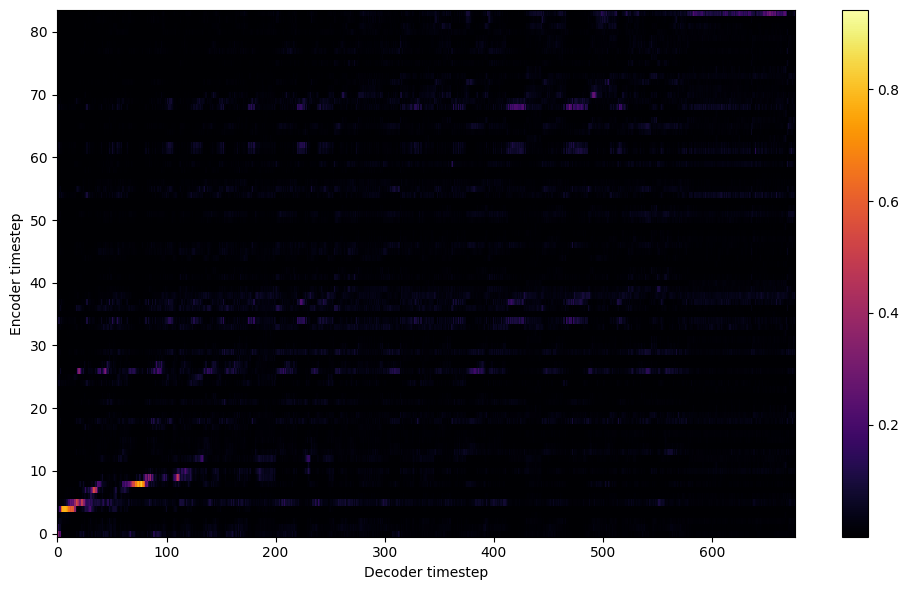


Starting Epoch: 1 Iteration: 2


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 1 Validation loss 4:  0.996639  Time: 0.1m LR: 0.000300


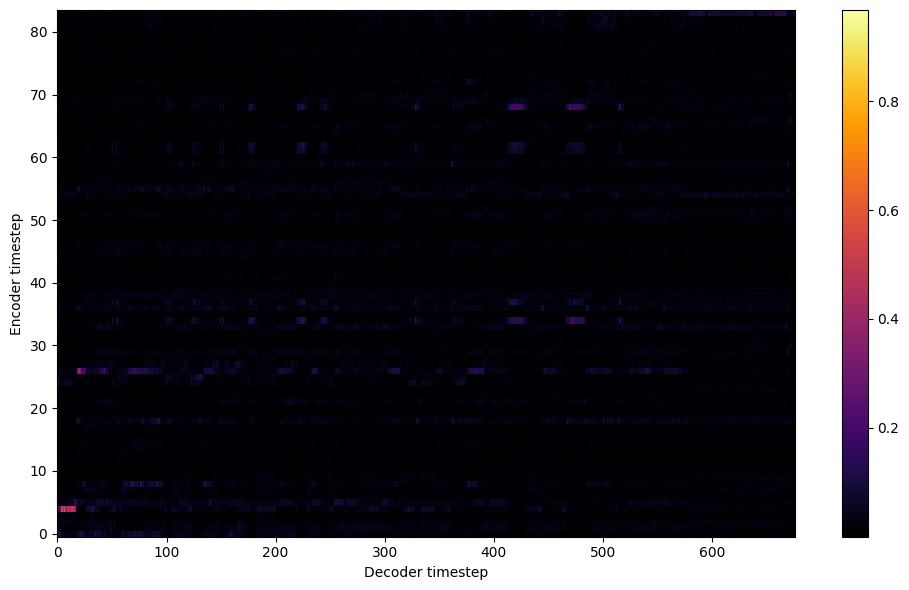


Starting Epoch: 2 Iteration: 4


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 2 Validation loss 6:  0.754541  Time: 0.1m LR: 0.000300


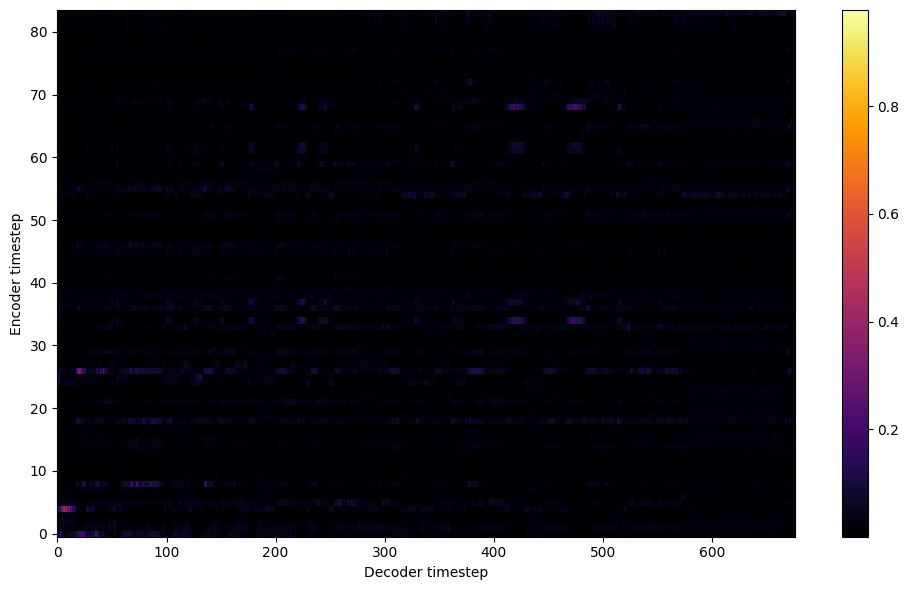


Starting Epoch: 3 Iteration: 6


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 3 Validation loss 8:  0.579205  Time: 0.1m LR: 0.000300


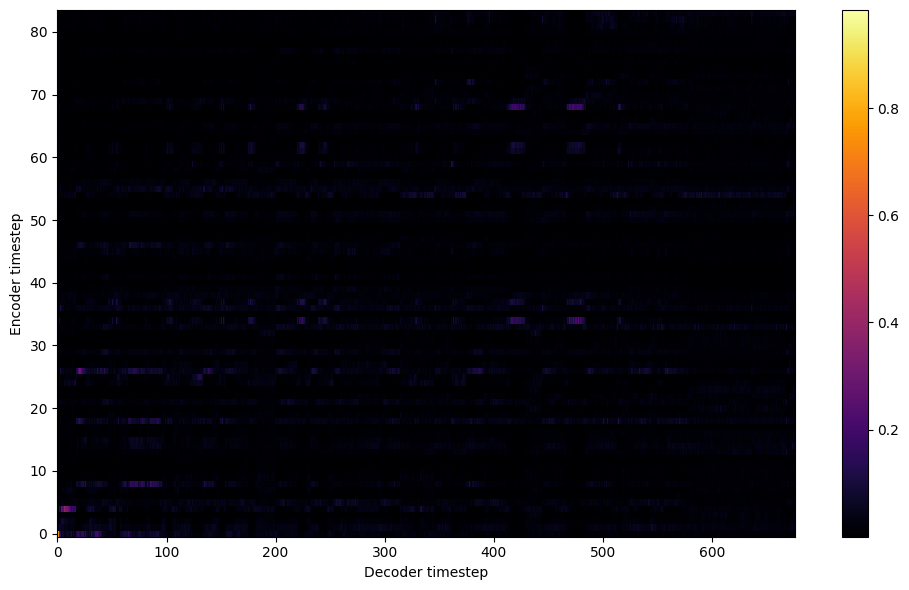


Starting Epoch: 4 Iteration: 8


  0%|          | 0/2 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [59]:
#@markdown ## **1. Begin training.** 🏋️
#@markdown ___
#@markdown ### How often to save (number of epochs)
#@markdown `10` by default. Raise this if you're hitting a rate limit. If you're using a particularly large dataset, you might want to set this to `1` to prevent loss of progress.
save_interval =  10#@param {type: "integer"}
#
#@markdown ### How often to backup (number of epochs)
#@markdown `-1` (disabled) by default. This will save extra copies of your model every so often, so you always have something to revert to if you train the model for too long. This *will* chew through your Google Drive storage.
backup_interval =  -1#@param {type: "integer"}
#

print(hparams)

print('FP16 Run:', hparams.fp16_run)
print('Dynamic Loss Scaling:', hparams.dynamic_loss_scaling)
print('Distributed Run:', hparams.distributed_run)
print('cuDNN Enabled:', hparams.cudnn_enabled)
print('cuDNN Benchmark:', hparams.cudnn_benchmark)
train(output_directory, log_directory, checkpoint_path,
      warm_start, n_gpus, rank, group_name, hparams, log_directory2,
      save_interval, backup_interval)

# **Final notes**

## A good training looks like this:
![img.png](https://media.discordapp.net/attachments/835971020569051216/851469553355587614/download_2.png)
